IMPORT

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from sqlalchemy import create_engine
from wordcloud import WordCloud
from tqdm import tqdm

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
load_dotenv()

PG_USER = os.getenv("PG_USER")
PG_PASS = os.getenv("PG_PASS")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB   = os.getenv("PG_DB")

Database preparing

In [3]:
DATABASE_URL = f"postgresql://{PG_USER}:{PG_PASS}@{PG_HOST}:{PG_PORT}/{PG_DB}"
engine = create_engine(DATABASE_URL)


In [4]:
CHUNK_SIZE = 50000

Basic analysis

In [5]:
cols_query = """
SELECT column_name, data_type 
  FROM information_schema.columns 
 WHERE table_name = 'tmp_news'
   AND table_schema = 'public'
"""
df_cols = pd.read_sql(cols_query, engine)
print("Table structure tmp_news:")
print(df_cols)

Table structure tmp_news:
     column_name                    data_type
0             id                         text
1          title                         text
2          anons                         text
3           body                         text
4  date_creation  timestamp without time zone


In [6]:
stats_query = """
SELECT 
    COUNT(*) AS total_rows,
    MIN(date_creation) AS min_date, 
    MAX(date_creation) AS max_date
  FROM public.tmp_news;
"""
df_stats = pd.read_sql(stats_query, engine)
total_rows = df_stats.loc[0, 'total_rows']
min_date = df_stats.loc[0, 'min_date']
max_date = df_stats.loc[0, 'max_date']
print(f"Total records number: {total_rows}")
print(f"Dates range: {min_date} — {max_date}")


Total records number: 2761431
Dates range: 2002-02-13 19:29:17 — 2024-10-23 02:58:15


In [7]:
import pandas as pd

query = """
SELECT
    char_length(title) AS title_len,
    char_length(anons) AS anons_len,
    char_length(body)  AS body_len
FROM public.tmp_news;
"""

chunks = pd.read_sql(query, engine, chunksize=100_000)
df_lengths = pd.concat(chunks, ignore_index=True)


In [8]:
summary = df_lengths.describe().T 

summary["mode"] = df_lengths.mode().iloc[0]

print(summary[["count", "mean", "std", "min", "25%", "50%", "75%", "max", "mode"]])

               count         mean          std  min    25%    50%     75%  \
title_len  2761399.0    59.823715    15.836909  2.0   49.0   59.0    70.0   
anons_len  2761431.0   192.178960    85.837393  1.0  131.0  191.0   248.0   
body_len   2761431.0  1414.016411  1450.102792  0.0  664.0  993.0  1687.0   

                max   mode  
title_len     267.0   59.0  
anons_len    2276.0  193.0  
body_len   310015.0    1.0  


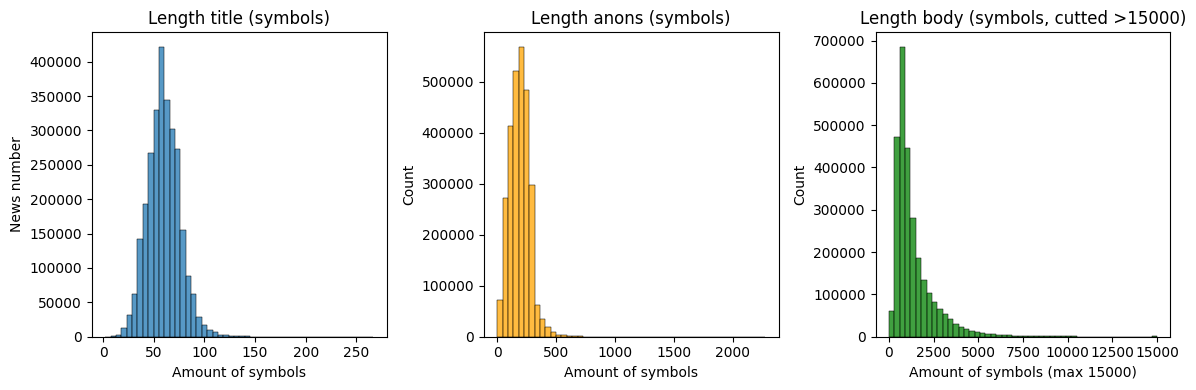

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df_lengths['title_len'], bins=50, kde=False)
plt.title("Length title (symbols)")
plt.xlabel("Amount of symbols")
plt.ylabel("News number")

plt.subplot(1, 3, 2)
sns.histplot(df_lengths['anons_len'], bins=50, kde=False, color='orange')
plt.title("Length anons (symbols)")
plt.xlabel("Amount of symbols")

plt.subplot(1, 3, 3)

sns.histplot(df_lengths['body_len'].clip(upper=15000), bins=50, kde=False, color='green')
plt.title("Length body (symbols, cutted >15000)")
plt.xlabel("Amount of symbols (max 15000)")

plt.tight_layout()
plt.show()

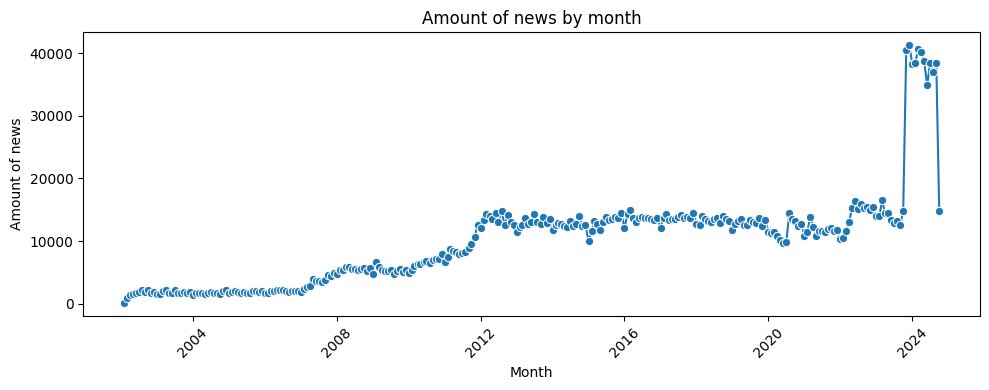

In [7]:
time_dist_query = """
SELECT 
    DATE_TRUNC('month', date_creation) AS month, 
    COUNT(*) AS cnt
  FROM public.tmp_news
 GROUP BY 1
 ORDER BY 1;
"""
df_time_dist = pd.read_sql(time_dist_query, engine)
df_time_dist['month'] = pd.to_datetime(df_time_dist['month'])

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_time_dist, x='month', y='cnt', marker="o")
plt.title("Amount of news by month")
plt.xlabel("Month")
plt.ylabel("Amount of news")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text analysis

In [10]:
russian_stopwords = set(nltk.corpus.stopwords.words("russian"))
russian_stopwords = russian_stopwords.union({"это", "который", "весь", "свой", "своего", "также", "однако"})

In [11]:
def tokenize_and_clean(text: str):
    text = text.lower()

    text = re.sub(r"[^а-яё]+", " ", text)
    tokens = nltk.word_tokenize(text, language="russian")
    tokens = [tok for tok in tokens if len(tok) > 2 and tok not in russian_stopwords]
    return tokens

In [12]:
title_counter = Counter()
anons_counter = Counter()

for chunk in tqdm(pd.read_sql(
    "SELECT title, anons FROM public.tmp_news;",
    engine,
    chunksize=CHUNK_SIZE
)):
    for title in chunk['title'].astype(str):
        tokens = tokenize_and_clean(title)
        title_counter.update(tokens)
    for anons in chunk['anons'].astype(str):
        tokens = tokenize_and_clean(anons)
        anons_counter.update(tokens)

56it [07:28,  8.00s/it]


In [13]:
top20_titles = title_counter.most_common(20)
top20_anons = anons_counter.most_common(20)
print("Top 20 title words:", top20_titles)
print("Top 20 anons words:", top20_anons)

Top 20 title words: [('россии', 112964), ('области', 109015), ('москве', 62849), ('сша', 61263), ('человек', 49908), ('путин', 49819), ('года', 43469), ('россия', 33561), ('рублей', 33168), ('дтп', 30860), ('лет', 26771), ('тысяч', 26445), ('день', 26044), ('москвы', 25956), ('новый', 25375), ('будут', 23255), ('году', 22439), ('районе', 21862), ('погибли', 21561), ('суд', 21520)]
Top 20 anons words: [('россии', 309925), ('области', 177285), ('сегодня', 160536), ('года', 157664), ('заявил', 127124), ('человек', 123375), ('сша', 107888), ('время', 105013), ('сообщил', 99057), ('году', 98923), ('лет', 94903), ('президент', 91437), ('глава', 87546), ('пресс', 85233), ('которые', 84184), ('владимир', 81655), ('сообщили', 78724), ('сообщает', 75874), ('москве', 75506), ('страны', 74372)]


/tmp/ipykernel_231238/1282100609.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_titles, x='count', y='word', palette='viridis')
/tmp/ipykernel_231238/1282100609.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_anons, x='count', y='word', palette='magma')


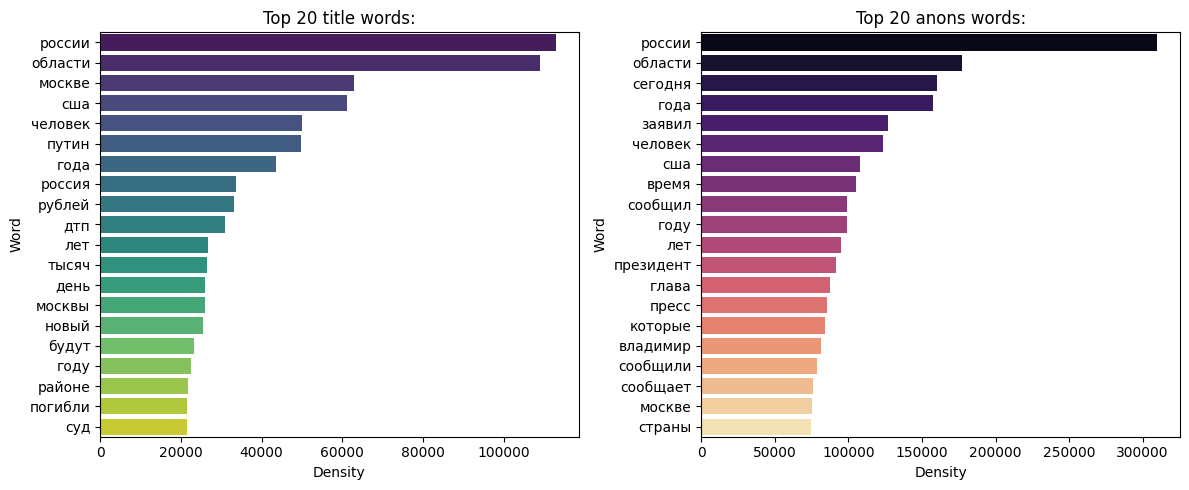

In [14]:
df_top_titles = pd.DataFrame(top20_titles, columns=['word', 'count'])
df_top_anons = pd.DataFrame(top20_anons, columns=['word', 'count'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=df_top_titles, x='count', y='word', palette='viridis')
plt.title("Top 20 title words:")
plt.xlabel("Density")
plt.ylabel("Word")

plt.subplot(1, 2, 2)
sns.barplot(data=df_top_anons, x='count', y='word', palette='magma')
plt.title("Top 20 anons words:")
plt.xlabel("Density")
plt.ylabel("Word")

plt.tight_layout()
plt.show()

Wordcloud

In [15]:
body_counter = Counter()
MAX_WORDS_BODY = 500_000

words_processed = 0
for chunk in tqdm(pd.read_sql(
    "SELECT body FROM public.tmp_news;",
    engine,
    chunksize=CHUNK_SIZE
)):
    for body in chunk['body'].astype(str):
        tokens = tokenize_and_clean(body)
        body_counter.update(tokens)
        words_processed += len(tokens)
        if words_processed >= MAX_WORDS_BODY:
            break
    if words_processed >= MAX_WORDS_BODY:
        break

0it [00:03, ?it/s]


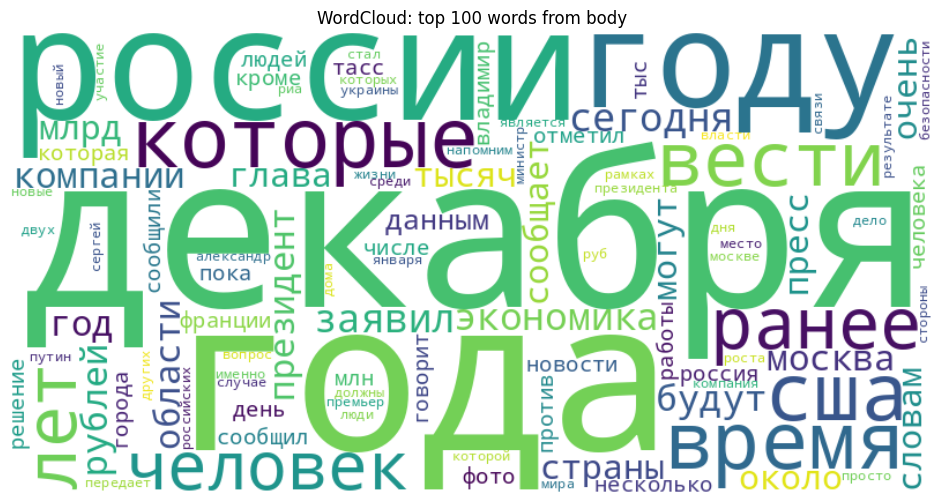

: 

In [ ]:
top_body = dict(body_counter.most_common(100))

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color="white", 
).generate_from_frequencies(top_body)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud: top 100 words from body")
plt.show()